# Exploratory Data analysis 
Hiro Naito

## Summary

* Several types of EDAs were performed: 
   * Feature correlation
   * Feature values VS target distribution
   * Simple logistic regression with one and two features
   * Cluster analysis 
* Overall, there were no clear signs of strong features to predict heart disease, at least in its simplest form. 
   * Only exception was Heart Attack, but we will likely remove that as a feature since it won't be an "early" sign of getting heart disease. 
* This either means: 
   * The feature + target relationships are complex and therefore cannot be done with simple modeling
   * We don't have enough features (or, feature engineering) to predict heart disease. 
* I noticed the age is capped at 80, and therefore all people that's older than 80 are put as 80. This is something to be cautious as we are using age (or similar) as a feature
   * If age (or similar) becomes really important as a feature, we may need to discard it, as it is obvious to check for heart disase if you're (very senior), and therefore the prediction will not be super helpful 

## Prep

In [73]:
# Few configurable initializations

TRAIN_PATH = '../data/processed/2021_data_train.csv' #Path to training data 
VAL_PATH = None #Path to validation data. If validation file doesn't exist, set as None
VAL_SIZE = 0.2 #If validation data has not been created, enter a value between 0 and and 1 to make a validation set on the fly. 
TARGET_COL = TARGET_COL
RANDOM_STATE = 1234

In [74]:
#Library and data import 

import pandas as pd 
import numpy as np
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.neighbors import NearestNeighbors, KNeighborsTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import DBSCAN

#Creating temporary validation set for light evaluation as part of EDA. 
if VAL_PATH is None or VAL_PATH == '': 
    from sklearn.model_selection import train_test_split
    trainval_df = pd.read_csv(TRAIN_PATH)
    train_df, val_df = train_test_split(trainval_df,test_size=VAL_SIZE,
        random_state=RANDOM_STATE,
        shuffle=True,
        stratify=trainval_df[TARGET_COL]
    )
    
else:
    train_df = pd.read_csv(TRAIN_PATH)
    val_df = pd.read_csv(VAL_PATH)

pd.set_option('display.max_columns', None)
RANDOM_SEED = 0


#Altair setup for themes
alt.renderers.enable('mimetype')
alt.theme.enable('default')
def apply_alt_config(chart):
    return chart.configure_axis(
        labelFontSize=14,
        titleFontSize=16
    ).configure_axisX(
        labelAngle=-45
    ).configure_legend(
        labelFontSize=12,
        titleFontSize=14
    ).configure_title(
        fontSize=18,
        anchor = 'middle'
    )



In [75]:
# Separate features by type of data for later analysis

#Categorical
cat_col = train_df.select_dtypes(include='object').columns.tolist()
cat_col.sort()
print(f"Categorical columns ({len(cat_col)})): {cat_col}")

#Binary
numeric_unique_count = train_df.select_dtypes(include='number').nunique()
bin_col = numeric_unique_count[(numeric_unique_count == 2) & (~numeric_unique_count.index.isin([TARGET_COL]))].index.values.tolist()
bin_col.sort()
print(f"Binary columns except Heart Disease ({len(bin_col)}): {bin_col}")

#We assume it's a quantitative column if it's a float or the minimum value is NOT 0 and 1 (in which case it's likely ordinal)

floats_col_idx = ((train_df.select_dtypes(include='number') % 1.0).sum() != 0)
float_col = floats_col_idx[floats_col_idx].index.to_list()
min_notzerone_col_idx = (train_df.select_dtypes(include='number').min())>= 2
min_notzerone_col = min_notzerone_col_idx[min_notzerone_col_idx].index.to_list()

#Get quantitative column by 
quant_col = train_df[list((set(float_col) | set(min_notzerone_col)))].columns.tolist()
quant_col.sort()
print(f"Quantitative columns ({len(quant_col)}): {quant_col}")

#Columns not identified by above are considered ordinal
ord_col = train_df[list(set(train_df.columns.to_list()) - set(cat_col+bin_col+quant_col+[TARGET_COL]))].columns.tolist()
ord_col.sort()
print(f"Ordinal columns ({len(ord_col)}): {ord_col}")

train_col = sorted(list(set(cat_col+bin_col+quant_col + ord_col)))

Categorical columns (2)): ['MaritalStatus', 'Race']
Binary columns except Heart Disease (15): ['Arthritis', 'AvoidedCareCost', 'Depression', 'Diabetes', 'DrankAlcohol', 'EverSmoked100Cigs', 'ExercisedPastMonth', 'HeartAttack', 'HighBloodPressure', 'HighCholesterol', 'ObeseFlag', 'OtherCancer', 'Sex', 'SkinCancer', 'Stroke']
Quantitative columns (4): ['AgeGroup', 'BMI', 'HeightCm', 'WeightKg']
Ordinal columns (12): ['AsthmaStatus', 'AvgDrinksPerDay', 'CheckupRecency', 'DrinksPerWeek', 'ECigUse', 'Education', 'GeneralHealth', 'Income', 'SmokelessTobacco', 'SmokingFrequency', 'SmokingQuantity', 'Unnamed: 0']


## Correlation

### Heart disease VS numeric variables (heatmap)

In [76]:

#Create (pearson) correlation matrics for numeric columns including binary and ordinal
corr_df = train_df[bin_col + quant_col + ord_col + [TARGET_COL]].corr(numeric_only=True).reset_index(names=['X']).melt(id_vars=['X'],var_name='Y',value_name='r')

corr_df = corr_df[corr_df['X'] <= corr_df['Y']]
heatmap = alt.Chart(corr_df).mark_rect().encode(
    x=alt.X('X:O', title='X'),
    y=alt.Y('Y:O', title='Y'),
    color=alt.Color('r:Q', scale=alt.Scale(scheme='redblue', domain=(-1, 1))),
    tooltip=['X', 'Y', 'r']
).properties(
    title='Correlation Heatmap',
    width=500,
    height=500
)
heatmap = apply_alt_config(heatmap)
heatmap


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


__Insights:__
* No variable has  high correlation with heart disease, except for heart attack. 
* There were few other variables that has mid/high correlation but nothing surprising (e.g. BMI and Obese, Sex and Height, etc)

### Heart disease VS ordinal & quantitative variables (area charts)

In [77]:
# Create dropdown widget
x_axis_widget = widgets.Dropdown(
    options=quant_col + ord_col,
    value=quant_col[0],
    description='X-axis:'
)
alt.renderers.enable('default')
def update_chart(x_col):
    # Aggregate data by selected x column
    round_df = train_df[[TARGET_COL,x_col]].round(0)
    agg_df = round_df.groupby([TARGET_COL,x_col]).size().reset_index(name='count')
 

    # Build chart
    chart1 = alt.Chart(agg_df).mark_bar().encode(
        x=alt.X(f'{x_col}:O', title=x_col),
        y=alt.Y('count:Q', title='Count'),
        color=alt.Color('HeartDisease:N'),
        tooltip=[x_col, alt.Tooltip('count', title='Count')]
    ).properties(
        width=500,
        height=300,
        title=f"Hearts disease vs {x_col}"
    )

    chart2 = chart1.encode(y=alt.Y('SOURCE:Q', title="Percentage", stack='normalize')).properties(title=f"Hearts disease vs {x_col} (100% chart)",)

    return apply_alt_config(chart1 | chart2)

# Tie widget to chart update
widgets.interact(update_chart, x_col=x_axis_widget)


interactive(children=(Dropdown(description='X-axis:', options=('AgeGroup', 'BMI', 'HeightCm', 'WeightKg', 'Ast…

<function __main__.update_chart(x_col)>

__Insights:__
* vs Age group reveals there are a lot of patients that's 80, as there is a cap of age 80. Not sure if this may cause unnecessary bias when using Age group
* There are a few ordinal features that seems counterintuitive to chances of having heart disease. Features AvgDrinksPerDay, CheckupRecency, and ECigUse have higher ratio of ppl with heart disease when the value is zero (which is better). This may be due to older people living more healthier, but due to age they had more chances of heart disease. 

### Heart disease VS categorical variables (bar charts)

In [78]:
# Create 2d list to store the charts
charts = []

# Convert to a regular Python list of lists
for i, col in enumerate(cat_col): 
    agg_df = train_df.groupby([TARGET_COL,col]).size().reset_index(name='count')
    x = (f'{col}:N',col)
    y = (f'count:Q','Count')
    color = (f'{TARGET_COL}:N','Heart Disease')

    chart1 = alt.Chart(agg_df).mark_bar().encode(
        x=alt.X(x[0], title=x[1]),
        y=alt.Y(y[0], title=y[1]),
        color=alt.Color(color[0]),
        tooltip=[
            alt.Tooltip(x[0], title=x[1]),
            alt.Tooltip(y[0], title=y[1]),
            alt.Tooltip(color[0], title = color[1]),
        ]
    ).properties(
        title=f"Hearts disease vs {col}",
        width=300,
        height=300
    )

    chart2 = chart1.encode(y=alt.Y(y[0], title="Percentage", stack='normalize')).properties(title=f"Hearts disease vs {col} (100% chart)",)
    charts.append([chart1,chart2])


for col in range(0, len(charts[0])):
    for row in range(0, len(charts)):
        if row == 0:
            combined_col = charts[row][col]
        else:
            combined_col = combined_col & charts[row][col] 
    if col == 0: 
        combined_all = combined_col
    else:
        combined_all = combined_all | combined_col

combined_all
#apply_alt_config(combined_all).properties(title = 'Heart disease VS Race (Count and 100% stack)')


alt.HConcatChart(...)

__Insights:__
* Nothing striking here

## Logistic regression analysis

### One feature

In [79]:
results = []
from sklearn.metrics import precision_recall_curve
X = None
y = None

#Go through each column/feature to create a univariate logistic regression model and evaluate
#Note that the script doesn't do any imputation of the features in both training and test set. We simply remove them. 

for col in train_df.drop(TARGET_COL,axis=1).columns.to_list():
    try:
        feature = col if col not in cat_col else 'C('+col+')'
        model = smf.logit(f"{TARGET_COL} ~ {feature}", missing='drop', data=train_df).fit(disp=0)

        X_val = val_df.loc[~val_df[col].isna(), [col]].copy()
        y_val = val_df.loc[X_val.index,TARGET_COL].astype(bool)
        y_pred = model.predict(X_val)

        
        #calcualte metrics and choose best threshold based on f1 score. 
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        best_thresh = thresholds[best_idx]

        #Make prediction based on best threshold, and store results into an array
        y_pred = (y_pred > best_thresh).astype(bool)
        results.append({
            'feature': col,
            'precision': precisions[best_idx],
            'recall': recalls[best_idx],
            'f1': f1_scores[best_idx],
            'threshold': best_thresh,
            'Predict_T': (y_pred==True).sum(),
            'Predict_F': (y_pred==False).sum(),
        })
        print(f"{col} done")
    except Exception as e:
        results.append({'feature': col, 'error': str(e)})

uni_results_df = pd.DataFrame(results)



Unnamed: 0 done
HeartAttack done
Stroke done
OtherCancer done
SkinCancer done
Arthritis done
Depression done
Diabetes done
HighBloodPressure done
HighCholesterol done
EverSmoked100Cigs done
SmokingFrequency done
ECigUse done
SmokelessTobacco done
SmokingQuantity done
DrankAlcohol done
AvgDrinksPerDay done
DrinksPerWeek done
ExercisedPastMonth done
GeneralHealth done
CheckupRecency done
AvoidedCareCost done
BMI done
ObeseFlag done
Sex done
AgeGroup done
Education done
Income done
Race done
MaritalStatus done
AsthmaStatus done
HeightCm done
WeightKg done


In [80]:
uni_results_df.sort_values(by='f1',ascending=False)

,feature,precision,recall,f1,threshold,Predict_T,Predict_F
1,HeartAttack,0.472222,0.447700,0.459634,0.483551,0,51881
19,GeneralHealth,0.150000,0.464573,0.226778,0.118841,2120,49886
25,AgeGroup,0.126913,0.440845,0.197087,0.101928,8527,43603
7,Diabetes,0.125588,0.379650,0.188741,0.124814,0,52026
9,HighCholesterol,0.101504,0.702260,0.177371,0.103472,0,44467
8,HighBloodPressure,0.098589,0.764082,0.174644,0.100748,0,51917
2,Stroke,0.202779,0.144164,0.168520,0.215878,0,52022
5,Arthritis,0.097532,0.591941,0.167470,0.097582,0,51833
29,MaritalStatus,0.108794,0.219861,0.145560,0.106558,0,51560
4,SkinCancer,0.110599,0.193407,0.140725,0.112546,0,51994


__Insights:__
* None of them really performed well, with majority of them only classifying as negative (i.e. not HeartDisease)

### Two (i.e. pairs of) features

In [81]:
#Now create logistic regression models for all pairs of features (+ interactive variable) to see if it reveals anything more than the univariate analysis. 
#Note that the script doesn't do any imputation of the features in both training and test set. We simply remove them. 
results = []
for col1 in train_col:
    print(f"{col1} START", end=" ")
    for col2 in train_col:
        if col1 >= col2: # This is to avoid redundant model building/fitting
            continue 
        try:
            print(f" {col2}, ", end=" ")
            feature1 = col1 if col1 not in cat_col else 'C('+col1+')'
            feature2 = col2 if col2 not in cat_col else 'C('+col2+')'
            #We will fit the two features with HeartDisease, including the interaction variable. 
            model = smf.logit(f"{TARGET_COL} ~ {feature1} * {feature2}", missing='drop', data=train_df).fit(disp=0)

            #Remove columns that had NaN before prediction. 
            X_val = val_df.loc[~val_df[col1].isna() & ~val_df[col2].isna(), [col1, col2]].copy()
            y_val = val_df.loc[X_val.index,TARGET_COL].astype(bool)
            y_pred = model.predict(X_val)


            precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
            best_idx = np.argmax(f1_scores)
            best_thresh = thresholds[best_idx]

            y_pred = (y_pred > best_thresh).astype(bool)
            results.append({
                'feature1': col1,
                'feature2': col2,
                'precision': precisions[best_idx],
                'recall': recalls[best_idx],
                'f1': f1_scores[best_idx],
                'threshold': best_thresh,
                'Predict_T': (y_pred==True).sum(),
                'Predict_F': (y_pred==False).sum(),
            })
        except Exception as e:
            results.append({'feature1': col1,'feature2': col2, 'error': str(e)})
    print(f"DONE")


bi_results_df = pd.DataFrame(results)



AgeGroup START  Arthritis,   AsthmaStatus,   AvgDrinksPerDay,   AvoidedCareCost,   BMI,   CheckupRecency,   Depression,   Diabetes,   DrankAlcohol,   DrinksPerWeek,   ECigUse,   Education,   EverSmoked100Cigs,   ExercisedPastMonth,   GeneralHealth,   HeartAttack,   HeightCm,   HighBloodPressure,   HighCholesterol,   Income,   MaritalStatus,   ObeseFlag,   OtherCancer,   Race,   Sex,   SkinCancer,   SmokelessTobacco,   SmokingFrequency,   SmokingQuantity,   Stroke,   Unnamed: 0,   WeightKg,  DONE
Arthritis START  AsthmaStatus,   AvgDrinksPerDay,   AvoidedCareCost,   BMI,   CheckupRecency,   Depression,   Diabetes,   DrankAlcohol,   DrinksPerWeek,   ECigUse,   Education,   EverSmoked100Cigs,   ExercisedPastMonth,   GeneralHealth,   HeartAttack,   HeightCm,   HighBloodPressure,   HighCholesterol,   Income,   MaritalStatus,   ObeseFlag,   OtherCancer,   Race,   Sex,   SkinCancer,   SmokelessTobacco,   SmokingFrequency,   SmokingQuantity,   Stroke,   Unnamed: 0,   WeightKg,  DONE
AsthmaStat

In [82]:
#Visualize using heatmap

heatmap = alt.Chart(bi_results_df).mark_rect().encode(
    x=alt.X('feature1:O', title='Feature'),
    y=alt.Y('feature2:O', title='Feature'),
    color=alt.Color('f1:Q', scale=alt.Scale(scheme='redblue', domain=(-1, 1))),
    tooltip=['feature1:O','feature2:O','precision:Q','recall:Q','f1:Q','threshold:Q','Predict_T:Q','Predict_F:Q']
).properties(
    title='Two feature logistic regression',
    width=500,
    height=500
)
heatmap = apply_alt_config(heatmap)
heatmap


alt.Chart(...)

__Insights:__
* As seen from other EDAs, usage of HeartAttack as a feature tends to bring higher F1 score. 
* As the shades of colors are similar horizontally and vertically, there aren't any particular pair of features that performed better. 

## Cluster analysis

In [83]:
cluster_df = train_df.copy()
cluster_df = pd.concat([cluster_df,pd.get_dummies(cluster_df[cat_col])],axis=1)
cluster_df  = cluster_df.drop(cat_col,axis=1).dropna().reset_index(drop=True)

for q_col in quant_col: 
    scaler = StandardScaler()
    cluster_df[q_col] = scaler.fit_transform(cluster_df[[q_col]])

cluster_cols = cluster_df.columns.to_list()

### Simple KNN

In [84]:
k=5
knn_model = NearestNeighbors(n_neighbors=k+1)  
knn_model.fit(cluster_df)

#Find closest cluster for each point, count the total. 
distances, indices = knn_model.kneighbors(cluster_df)
min_dist = np.min(distances[:,1:],axis=1)
min_mask = np.tile(min_dist[:, np.newaxis], (1, k))

pd.DataFrame(distances[:,1:] == min_mask).sum()



0    76436
1        0
2        0
3        0
4        0
dtype: int64

__Insights:__
* KNN doesn't do any clustering, regardless of # of clusters chosen. 

### DBSCAN
As KNN didn't tell much, trying DBSCAN

#### Euclidean

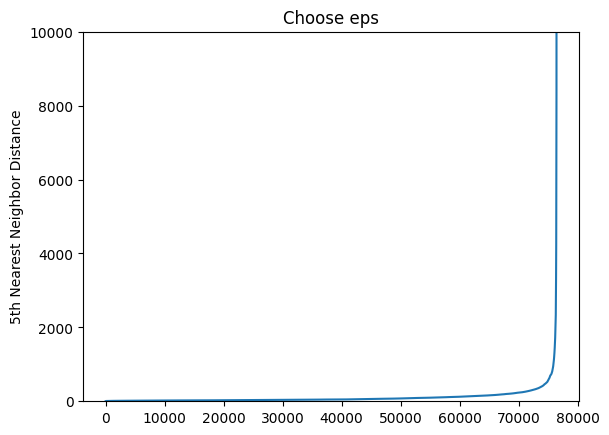

In [85]:
#Look at the elbow shape to find eps to use for DBSCAN
knn_model = NearestNeighbors(n_neighbors=5+1)  # +1 to include the point itself
knn_model.fit(cluster_df)

distances, indices = knn_model.kneighbors(cluster_df)

k_dist = np.sort(distances[:, 5])  # 5-1 = 4
plt.plot(k_dist)
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("Choose eps")
plt.ylim(0, 10000)
plt.show()


In [86]:
#Looking at above graph, I'll pick eps around 220
db_eu = DBSCAN(eps=220, min_samples=5, metric='euclidean').fit(cluster_df)
cluster_df_dbeu = pd.concat([cluster_df, pd.Series(db_eu.labels_,name='db_eu_idx')],axis=1)
db_eu_df = pd.pivot_table(data=cluster_df_dbeu, 
                          index='db_eu_idx',
                          values=[TARGET_COL],
                          aggfunc=['count','sum']).reset_index()
db_eu_df.columns = ['_'.join(col) for col in db_eu_df.columns]
db_eu_df[f'{TARGET_COL}_pct_cluster'] = db_eu_df[f'sum_{TARGET_COL}'] / db_eu_df[f'count_{TARGET_COL}']
db_eu_df[f'{TARGET_COL}_total'] = db_eu_df[f'sum_{TARGET_COL}'] / db_eu_df[f'sum_{TARGET_COL}'].sum()
db_eu_df['count_pct_total'] = db_eu_df[f'count_{TARGET_COL}'] / db_eu_df[f'count_{TARGET_COL}'].sum()
db_eu_df.rename(columns = {'db_eu_idx_':'Cluster ID',
                           f'sum_{TARGET_COL}':'Cluster Heart Disease',
                           f'count_{TARGET_COL}':'Cluster Total',
                           'count_pct_total':'Cluster total / Total',
                           f'{TARGET_COL}_pct_cluster':'Cluster Heart disease / Cluster total',
                           f'{TARGET_COL}_total':'Cluster Heart disease / Heart disease Total',}
                           )



,Cluster ID,Cluster Total,Cluster Heart Disease,Cluster Heart disease / Cluster total,Cluster Heart disease / Heart disease Total,Cluster total / Total
0,-1,4344,130.0,0.029926,0.040086,0.056832
1,0,48910,2106.0,0.043059,0.649399,0.639882
2,1,20861,848.0,0.040650,0.261486,0.272921
3,2,470,54.0,0.114894,0.016651,0.006149
4,3,5,1.0,0.200000,0.000308,0.000065
...,...,...,...,...,...,...
124,123,5,0.0,0.000000,0.000000,0.000065
125,124,4,0.0,0.000000,0.000000,0.000052
126,125,5,0.0,0.000000,0.000000,0.000065
127,126,5,0.0,0.000000,0.000000,0.000065


#### Hamming

In [88]:
db_ham = DBSCAN(eps=0.1, min_samples=5, metric='hamming').fit(cluster_df)

cluster_df_dbham = pd.concat([cluster_df, pd.Series(db_ham.labels_,name='db_ham_idx')],axis=1)
db_ham_df = pd.pivot_table(data=cluster_df_dbham, 
                          index='db_ham_idx',
                          values=[TARGET_COL],
                          aggfunc=['count','sum']).reset_index()
db_ham_df.columns = ['_'.join(col) for col in db_ham_df.columns]
db_ham_df[f'{TARGET_COL}_pct_cluster'] = db_ham_df[f'sum_{TARGET_COL}'] / db_ham_df[f'count_{TARGET_COL}']
db_ham_df[f'{TARGET_COL}_total'] = db_ham_df[f'sum_{TARGET_COL}'] / db_ham_df[f'sum_{TARGET_COL}'].sum()
db_ham_df['count_pct_total'] = db_ham_df[f'count_{TARGET_COL}'] / db_ham_df[f'count_{TARGET_COL}'].sum()
db_ham_df.rename(columns = {'db_eu_idx_':'Cluster ID',
                           f'sum_{TARGET_COL}':'Cluster Heart Disease',
                           f'count_{TARGET_COL}':'Cluster Total',
                           'count_pct_total':'Cluster total / Total',
                           f'{TARGET_COL}_pct_cluster':'Cluster Heart disease / Cluster total',
                           f'{TARGET_COL}_total':'Cluster Heart disease / Heart disease Total',}
                           )


,db_ham_idx_,Cluster Total,Cluster Heart Disease,Cluster Heart disease / Cluster total,Cluster Heart disease / Heart disease Total,Cluster total / Total
0,-1,69442,3226.0,0.046456,0.994758,0.908499
1,0,5640,14.0,0.002482,0.004317,0.073787
2,1,6,0.0,0.000000,0.000000,0.000078
3,2,51,0.0,0.000000,0.000000,0.000667
4,3,53,0.0,0.000000,0.000000,0.000693
...,...,...,...,...,...,...
143,142,3,0.0,0.000000,0.000000,0.000039
144,143,5,0.0,0.000000,0.000000,0.000065
145,144,5,0.0,0.000000,0.000000,0.000065
146,145,7,0.0,0.000000,0.000000,0.000092


__Insights:__ 
* When using DBSCAN w/ Euclidean, there were some separation via clusters, but rate of heart disease ppl in each cluster was not hugely different (i.e. not helpful)
* When using DBSCAN w/ Hamming, it did some clustering of data points, majority (80%) of the points are unclustered even with change in hyperparameters